# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.6.0
# sklearn 0.24.2

## Setup

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
tf.config.run_functions_eagerly(True)

Assign device (GPU)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

### Test set

In [5]:
# minimum sq
sq_min = np.exp(-5)

In [6]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

In [7]:
sq_test.shape

(18750, 80)

In [8]:
eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

In [9]:
sq_dim = sq_test.shape[1]
sample_test_dim = sq_test.shape[0]

$Q\cdot r_\textrm{ave}$

In [10]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [11]:
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],
                                                  fill_value='extrapolate',kind='linear')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

### Mask

In [12]:
mask_length = 0
sq_test_mask = sq_test_rs

for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

### Preprocess/Postprocess

In [13]:
exp_scale = 3

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

## Network architecture

In [14]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [15]:
latent_dim = 3
model = VAE(latent_dim, q_rs_dim)

## Load trained model

In [16]:
export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_batch32'
export_name = export_path + model_name

In [17]:
reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
reload_sm.__dict__

{'_checkpoint': <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator at 0x1ff0cbcd370>,
 '_feed_dict': None,
 '_graph_view': <tensorflow.python.training.tracking.graph_view.ObjectGraphView at 0x1ff0cece400>,
 '_root': <__main__.VAE at 0x1ff7aee15e0>}

In [18]:
model_r = reload_sm._root
#model_r.__dict__

### Loaded network architecture

In [19]:
class VAE_r():
    def __init__(self):
        self.encoder = model_r.encoder
        self.decoder = model_r.decoder
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
M = VAE_r() # loaded model

In [20]:
def decoder_mean(model,lv):
    x = model.sample(lv)
    
    return x

def encoder_mean(model,x):
    mean = model.encode(x)[0]
    
    return mean

## Define functions 

In [21]:
exp_scale = 3

@tf.function
def f_inp_tf(sq):
    return tf.math.log(sq)/exp_scale/2 + 0.5

@tf.function
def f_out_tf(predictions):
    return tf.math.exp((predictions*2-1)*exp_scale)

In [22]:
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [23]:
def hardsphere(q,sigma=1):
    R = to_tf(sigma/2)
    P = (3*(tf.math.sin(q*R)-q*R*tf.math.cos(q*R))/(q*R)**3)**2
    return P
    
    
def interpolation_tf(q,x,scale):
    qs = q*scale
    x_interp = tfp.math.interp_regular_1d_grid(
        to_tf(qs), tf.math.reduce_min(to_tf(q)), tf.math.reduce_max(to_tf(q)), x)
    return x_interp

def IQ_th(model, fp):
    # form factor
    P = hardsphere(q,fp[3])
    
    # structure factor
    lv = tf.reshape(to_tf(fp[0:3]),(1,3))
    x_logit = decoder_mean(model,lv)
    S = f_out_tf(x_logit)
    
    # I(Q)
    IQ_th = S*P
    
    # interpolation
    IQ_th_interp = interpolation_tf(q,IQ_th,fp[3])
    return IQ_th_interp

def fit_loss(model, x, fp):
    x_th = IQ_th(model, fp)
    
    # mean-square error
    err = tf.reduce_mean((x_th-x)**2)
    
    return err

In [24]:
@tf.function
def train_step(model, x, fp, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = fit_loss(model, x, fp)
    gradients = tape.gradient(loss, fp)
    optimizer.apply_gradients(zip(gradients, fp))

In [25]:
def generate_image(model, IQ_exp, fp, epoch=0):
    error = fit_loss(model, IQ_exp, fp)
    IQ_th_current = IQ_th(model, fp)[0,:]
    
    #display.clear_output(wait=False)
    
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1)
    plt.plot(q,IQ_exp,'k')
    plt.plot(q,IQ_th_current,'b')
    plt.text(0.6,0.96,'MSE = {:.2e}'.format(error),transform=ax.transAxes)
    plt.text(0.8,0.96,'lv[0] = {:+.2f}'.format(fp[0].numpy()),transform=ax.transAxes)
    plt.text(0.8,0.90,'lv[1] = {:+.2f}'.format(fp[1].numpy()),transform=ax.transAxes)
    plt.text(0.8,0.84,'lv[2] = {:+.2f}'.format(fp[2].numpy()),transform=ax.transAxes)
    plt.text(0.8,0.78,'$\sigma$ = {:+.2f}'.format(fp[3].numpy()),transform=ax.transAxes)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(3, 16)
    #plt.ylim(3e-4, 0.3)
    plt.xlabel('$Q$')
    plt.ylabel('$I(Q)$')
    
    pngname = './figures_SQ_cVAE_MSE_ns/fit/fit_{:04d}.png'
    plt.savefig(pngname.format(epoch))
    plt.close()
    #plt.show()
    #print('epoch = {:04d}'.format(epoch))
    #time.sleep(0.1)

## Pick an I(Q) and test

In [26]:
index_test = 18010
sigma_test = 1.0
SQ_exp = sq_test_mask[index_test,:]
lv_GT = encoder_mean(M,to_tf(f_inp(SQ_exp.reshape((1,80)))))

SQ_exp = to_tf(SQ_exp)
P = hardsphere(q,1)
IQ_exp = SQ_exp*P
IQ_exp = interpolation_tf(q,IQ_exp,1.0)

fp_GT = [lv_GT[0,0],lv_GT[0,1],lv_GT[0,2],to_tf(sigma_test)]

### Initial value

In [27]:
# tf.constant("Initial Guess")
sigma_i = tf.constant(0.9)
lv0_i = tf.constant(-4.0)
lv1_i = tf.constant(4.0)
lv2_i = tf.constant(4.0)

# constraint=lambda t: tf.clip_by_value(t, "Lower Bound", "Upper Bound")
sigma = tf.Variable(sigma_i, name='sigma', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 1, 1))
lv0 = tf.Variable(lv0_i, name='lv0', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))
lv1 = tf.Variable(lv1_i, name='lv1', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))
lv2 = tf.Variable(lv2_i, name='lv2', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))

fp = [lv0,lv1,lv2,sigma]

---
### Fit

In [28]:
generate_image(M, IQ_exp, fp)
epochs = 200

import progressbar
bar = progressbar.ProgressBar(maxval=epochs, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

optimizer = tf.keras.optimizers.Adam(0.1)
start_time = time.time()

for epoch in range(1, epochs + 1):
    train_step(M, IQ_exp, fp, optimizer)
    
    bar.update(epoch)
    #sleep(0.1)
    
    # generate image
    if 1:
        if epoch%5 == 0:
            generate_image(M, IQ_exp, fp, epoch)

end_time = time.time()
bar.finish()

print('time elapsed = {:0.2f}s'.format(end_time - start_time))

time elapsed = 16.80s


### Display animated GIF


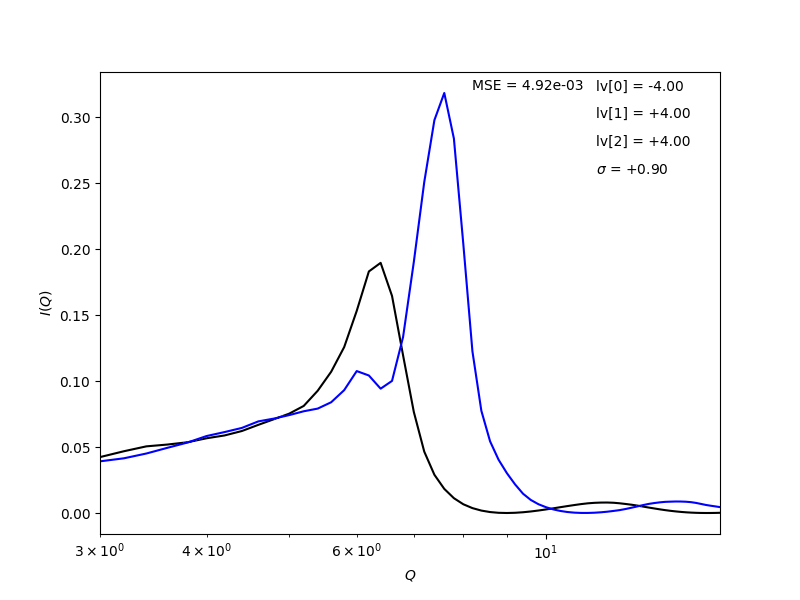

In [29]:
anim_file = './figures_SQ_cVAE_MSE_ns/fit/fit.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures_SQ_cVAE_MSE_ns/fit/fit_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

---

In [30]:
fp_GT[0:3]

[<tf.Tensor: shape=(), dtype=float32, numpy=-4.0751944>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.215626>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.4741917>]

In [31]:
fp[0:3]

[<tf.Variable 'lv0:0' shape=() dtype=float32, numpy=-4.0639215>,
 <tf.Variable 'lv1:0' shape=() dtype=float32, numpy=3.148937>,
 <tf.Variable 'lv2:0' shape=() dtype=float32, numpy=4.3748174>]

In [32]:
parameters = (eta_test,kappa_test,lnA_test)
parameters_GP = np.vstack(parameters).T
index_eta = np.arange(sq_test.shape[0])

In [33]:
parameters_GP[18010,:]

array([0.435    , 0.42     , 2.3978953], dtype=float32)

## Test GPR model

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib

In [35]:
with np.load(export_path +'lv_SVD_batch32.npz') as data:
    z_mean = data['z_mean']
    U = data['U']
    sgn = data['sgn']

In [36]:
print(U)
print(z_mean)
print(sgn)

[[-0.5418036  -0.6347781  -0.5509135 ]
 [ 0.6416007   0.11105872 -0.7589562 ]
 [ 0.5429525  -0.7646717   0.34710205]]
[-1.6351871   0.05107004  2.8202484 ]
[-1. -1. -1.]


In [37]:
export_path_GPR = './saved_model/GPR/' 
model_name_GPR = 'sklearn/model_GPR_lnA'
export_name_GPR = export_path_GPR + model_name_GPR
gp = joblib.load(export_name_GPR)

In [38]:
fp_p = np.matmul([fp[0:3],]-z_mean,U)*sgn
fp_GT_p = np.matmul([fp_GT[0:3],]-z_mean,U)*sgn

In [39]:
gp.predict(fp_GT_p)

array([2.38814609])